In [ ]:
# If you run this script in colab
# !git clone https://github.com/pai-sj/ocr-text-recognition.git
# import sys
# sys.path.append("./ocr-text-recognition/")
# !pip install -r ./ocr-text-recognition/requirements.txt

In [1]:
%matplotlib inline
import numpy as np
import cv2
    
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

import tensorflow as tf 
assert int(tf.__version__[:1]) < 2.0, "해당 코드는 1.x에서만 동작합니다."
tf.logging.set_verbosity(tf.logging.ERROR)

# \[ MNIST 데이터셋 \]

MNIST 데이터셋을 통해 정상적으로 동작하는지를 확인해보도록 함

## 1. 데이터 가져오기 

In [2]:
from utils.dataset import SerializationDataset

train_set = SerializationDataset('mnist','train',
                                 digit=5,pad_range=(3,10))
validation_set = SerializationDataset('mnist','validation',
                                      digit=5,pad_range=(3,10))
test_set = SerializationDataset('mnist','test',
                                digit=(3,8),pad_range=(3,10))

## 2. 데이터 Generator 가져오기

In [3]:
from models.generator import Seq2SeqGenerator

train_gen = Seq2SeqGenerator(train_set, 
                          batch_size=32)
valid_gen = Seq2SeqGenerator(validation_set, 
                          batch_size=100, 
                          shuffle=False)
test_gen = Seq2SeqGenerator(test_set, 
                         batch_size=500, 
                         shuffle=False)

conv2text = test_gen.convert2text

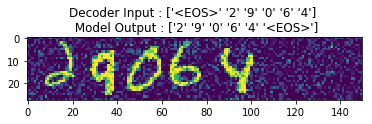

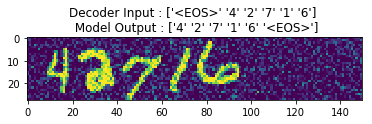

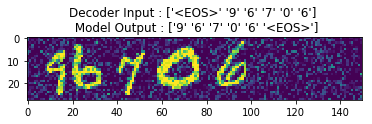

In [4]:
X,Y = train_gen[0]
for i in range(3):
    image = X['images'][i,:,:,0]
    dec_input = X['decoder_inputs'][i]
    dec_input = conv2text(dec_input)
    
    output = Y['output_seqs'][i]
    output = conv2text(output)

    plt.title(f"Decoder Input : {dec_input} \n Model Output : {output}")
    plt.imshow(image)
    plt.show()

> CRNN과 다른 데이터셋이 필요합니다. CRNN과 달리, Images, Decoder Input, Model Output 이렇게 총 3개의 데이터가 필요합니다. Decoder Input과 Model Output은 1번의 Time Step 만큼 차이가 납니다. 

# \[ 4. Residual-SRN(Sequence Recognition Network) 구성하기 \]
----
----

BLSTM 레이어를 제거하고, Convolution 레이어를 추가하는 방향으로 변경하였습니다.

## 1. Res-Net Style Convolution Feature Extractor 구성하기
----


In [5]:
from models.layers import Map2Sequence, DotAttention

from tensorflow.keras.layers import Conv2D, LayerNormalization, MaxPooling2D, Dense
from tensorflow.keras.layers import Embedding, GRU, concatenate
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras import backend as K

In [6]:
class ResidualConvFeatureExtractor(Layer):
    """
    Residual Block & KAKAO OCR Like Text Recognition Model
    [ conv2d - layer norm - conv2d - layer norm - maxpool ] * 3

    특징
     1. Batch Normalization 대신 Layer Normalization을 이용(높이와 채널 축으로만 진행)
        RNN 모델에서는 주로 BN 보다는 LN을 쓴다고 함.
        Layer Normalization은 Hidden unit들에 대해서 Mean과 Variance를 구함
     2. KAKAO와 달리 Block 수를 4개로 진행 (보다 넓은 범위를 탐색하기 위함)
     3. Residual Block을 두어서 보다 빠르게 학습가능하도록 설정

    """
    def __init__(self, n_hidden=64, **kwargs):
        self.n_hidden = n_hidden
        super().__init__(**kwargs)
        # for builing Layer and Weight
        self.conv1_1 = Conv2D(n_hidden, (3, 3), activation='relu', padding='same')
        self.lnorm1_1 = LayerNormalization(axis=(1, 3)) # Normalizing height & Channel
        self.conv1_2 = Conv2D(n_hidden, (3, 3), padding='same')
        self.lnorm1_2 = LayerNormalization(axis=(1, 3)) # Normalizing height & Channel
        self.maxpool1 = MaxPooling2D((2, 2), (2, 2), padding='same')

        self.conv2_skip = Conv2D(n_hidden*2, (1, 1), activation='relu', padding='same')
        self.conv2_1 = Conv2D(n_hidden*2, (3, 3), activation='relu', padding='same')
        self.lnorm2_1 = LayerNormalization(axis=(1, 3)) # Normalizing height & Channel
        self.conv2_2 = Conv2D(n_hidden*2, (3, 3), padding='same')
        self.lnorm2_2 = LayerNormalization(axis=(1, 3)) # Normalizing height & Channel
        self.maxpool2 = MaxPooling2D((2, 2), (2, 2), padding='same')

        self.conv3_skip = Conv2D(n_hidden * 4, (1, 1), activation='relu', padding='same')
        self.conv3_1 = Conv2D(n_hidden*4, (3, 3), activation='relu', padding='same')
        self.lnorm3_1 = LayerNormalization(axis=(1, 3)) # Normalizing height & Channel
        self.conv3_2 = Conv2D(n_hidden*4, (3, 3), padding='same')
        self.lnorm3_2 = LayerNormalization(axis=(1, 3)) # Normalizing height & Channel
        self.maxpool3 = MaxPooling2D((2, 1), (2, 1), padding='same')

        self.conv4_skip = Conv2D(n_hidden * 4, (1, 1), activation='relu', padding='same')
        self.conv4_1 = Conv2D(n_hidden*4, (3, 3), activation='relu', padding='same')
        self.lnorm4_1 = LayerNormalization(axis=(1, 3)) # Normalizing height & Channel
        self.conv4_2 = Conv2D(n_hidden*4, (3, 3), padding='same')
        self.lnorm4_2 = LayerNormalization(axis=(1, 3)) # Normalizing height & Channel
        self.maxpool4 = MaxPooling2D((2, 1), (2, 1), padding='same')
        self.built = True

    def call(self, inputs, **kwargs):
        x = self.conv1_1(inputs)
        x = self.lnorm1_1(x)
        x = self.conv1_2(x)
        x = self.lnorm1_2(x)
        x = self.maxpool1(x)

        skip = self.conv2_skip(x)
        x = self.conv2_1(x)
        x = self.lnorm2_1(x)
        x = self.conv2_2(x)
        x = self.lnorm2_2(x)
        x = K.relu(skip + x)
        x = self.maxpool2(x)

        skip = self.conv3_skip(x)
        x = self.conv3_1(x)
        x = self.lnorm3_1(x)
        x = self.conv3_2(x)
        x = self.lnorm3_2(x)
        x = K.relu(skip + x)
        x = self.maxpool3(x)

        skip = self.conv4_skip(x)
        x = self.conv4_1(x)
        x = self.lnorm4_1(x)
        x = self.conv4_2(x)
        x = self.lnorm4_2(x)
        x = K.relu(skip + x)
        x = self.maxpool4(x)
        return x

    def get_config(self):
        config = {
            "n_hidden": self.n_hidden
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

## 2. 전체 모델 구성하기

In [8]:
K.clear_session()

height = 28
num_classes = 10
n_conv = 16 # the number of Convolution filter
n_state = 32 # the number of BLSM units
n_embed = 3 # the size of embedding vector
n_clf = 32 # the number of units in classifier Dense layer

# Image Encoder
inputs = Input(shape=(height, None, 1),name='images')
conv_maps = ResidualConvFeatureExtractor(n_conv,
                                         name='feature_extractor')(inputs)
feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)
states_encoder = Dense(n_state, activation='tanh')(feature_seqs)

# Embedding Layer
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
embedding_layer = Embedding(num_classes+1, n_embed)
embedding_target = embedding_layer(decoder_inputs)

# Text Decoder
decoder_state_inputs = Input(shape=(n_state,), name='decoder_state')
gru_layer = GRU(n_state, 
                name='decoder_gru', 
                return_sequences=True)
states_decoder = gru_layer(embedding_target,
                           initial_state=decoder_state_inputs)

# Attention Layer
dotattend = DotAttention()
context, attention = dotattend([states_encoder, states_decoder])

# Classifier Layer
clf1_layer = Dense(n_clf, activation='relu')
clf2_layer = Dense(num_classes+1, activation='softmax',name='output_seqs')

concat_output = concatenate([context, states_decoder], name='concat_output')
fc_outputs = clf1_layer(concat_output)
predictions = clf2_layer(fc_outputs)

## (8) 추론 모델과 학습 모델 구성하기

In [9]:
from tensorflow.keras.models import Model

In [10]:
# For training
trainer = Model([inputs, 
                 decoder_inputs,
                 decoder_state_inputs], 
                predictions, name='trainer')

# For Inference
# - (1) Encoder
encoder = Model(inputs, states_encoder, 
                name='encoder')

# - (2) Decoder
states_encoder_input = Input((None,n_state), 
                             name='states_encoder_input')

context, attention = dotattend([states_encoder_input, states_decoder])
concat_output = concatenate([context, states_decoder], axis=-1, 
                            name='concat_output')
fc_outputs = clf1_layer(concat_output)
predictions = clf2_layer(fc_outputs)

decoder = Model([states_encoder_input, decoder_inputs, decoder_state_inputs], 
                [states_decoder, predictions], name='decoder')

## (9) 학습 모델 Compile하기

In [11]:
from models.optimizer import AdamW
from models.losses import masking_sparse_categorical_crossentropy

In [17]:
y_true = tf.placeholder(shape=(None, None), dtype=tf.int32)

trainer.compile(AdamW(lr=1e-2),
                loss={"output_seqs":masking_sparse_categorical_crossentropy(-1)},
                target_tensors=[y_true])

## (10) 모델 학습하기

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [19]:
callbacks =[]
rlrop = ReduceLROnPlateau(
    factor=0.5, patience=5, 
    min_lr=1e-6, verbose=1)
callbacks.append(rlrop)

epochs = 20

In [20]:
train_gen = Seq2SeqGenerator(train_set, 
                          batch_size=32,
                          state_size=n_state)
valid_gen = Seq2SeqGenerator(validation_set, 
                             batch_size=100,
                             shuffle=False,
                             state_size=n_state)                            
test_gen = Seq2SeqGenerator(test_set, 
                            batch_size=500, 
                            shuffle=False,
                            state_size=n_state)                                                        

In [ ]:
hist = trainer.fit_generator(train_gen,
                             epochs=epochs,
                             validation_data=valid_gen,
                             callbacks=callbacks)

Epoch 1/20
343/343 [==============================] - 150s 437ms/step - loss: 1.9314 - val_loss: 1.9223
Epoch 2/20
343/343 [==============================] - 141s 412ms/step - loss: 1.9197 - val_loss: 1.9192
Epoch 3/20
343/343 [==============================] - 134s 392ms/step - loss: 1.9194 - val_loss: 1.9197
Epoch 4/20
343/343 [==============================] - 144s 420ms/step - loss: 1.9632 - val_loss: 2.4624
Epoch 5/20
 80/343 [=====>........................] - ETA: 1:48 - loss: 2.3878

## (11) 모델 평가하기

In [ ]:
EOS_TOKEN = 10

In [ ]:
X,_ = test_gen[0]

# Target image 
target_images = X['images'][:10]

# Encoder 결과 계산
states_encoder_ = encoder.predict(target_images)

In [ ]:
# Decoder
batch_size = target_images.shape[0]

prev_inputs = np.ones((batch_size,1)) * EOS_TOKEN
prev_states = np.zeros((batch_size, 512))

In [ ]:
result = prev_inputs.copy()
while True:
    states_decoder_, predictions_ = decoder.predict({
        "states_encoder_input" : states_encoder_,
        "decoder_inputs": prev_inputs,
        "decoder_state": prev_states        
    })
    prev_states = states_decoder_[:,-1,:]
    prev_inputs = np.argmax(predictions_,axis=-1)
    
    if np.all(prev_inputs == EOS_TOKEN):
        break
    result = np.concatenate([result,prev_inputs],axis=-1)
result = result[:,1:].squeeze()

In [ ]:
for image, seq in zip(target_images,result):
    plt.title(seq)
    plt.imshow(image[:,:,0])
    plt.show()